## This notbook shows Flight Fare Prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_excel("Data_Train_Flight.xlsx")
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
train_df.shape

(10683, 11)

<AxesSubplot:>

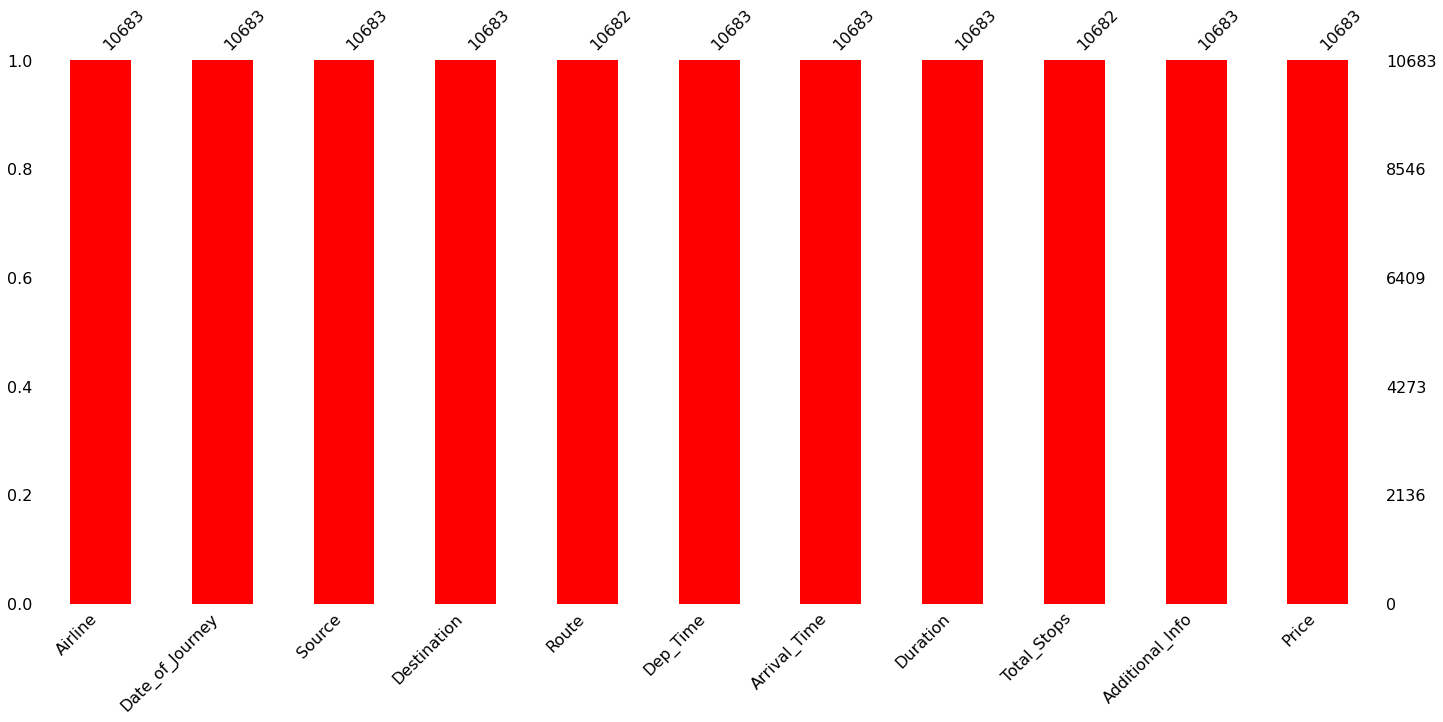

In [4]:
import missingno as msm
msm.bar(train_df,color='red')

* we clearly see that from the bar graph there is one null value in the Route and Total_stops so we can drop this column

In [5]:
train_df.dropna(axis=0,inplace=True)

In [6]:
train_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


## we performe EDA on train data

#### In the dataset there are many columns in date and time format so we can convert that column in proper format

In [8]:
# convert date into day of journey and month of journey
train_df['Day_of_Journey'] = pd.to_datetime(train_df['Date_of_Journey']).dt.day
train_df['Month_of_Journey'] = pd.to_datetime(train_df['Date_of_Journey']).dt.month

# drop the Date_of_Journey column
train_df.drop('Date_of_Journey',axis=1, inplace=True)

* similar way we can convert Dep_time , Arrival_time , Duration in proper format

In [9]:
# convert Arrival_time into Hour and minute 
train_df['Arrival_hour'] = pd.to_datetime(train_df['Arrival_Time']).dt.hour
train_df['Arrival_minute'] = pd.to_datetime(train_df['Arrival_Time']).dt.minute

# drop Arrival_time
train_df.drop('Arrival_Time', axis=1, inplace =True)

In [10]:
# convert Dep_Time into Hour and minute 
train_df['Dep_hour'] = pd.to_datetime(train_df['Dep_Time']).dt.hour
train_df['Dep_minute'] = pd.to_datetime(train_df['Dep_Time']).dt.minute

# drop Dep_Time
train_df.drop('Dep_Time', axis=1, inplace =True)

In [11]:
# Now we convert Duration into proper format into Duration_hour and Duration_minute
duration = list(train_df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i]=duration[i] + " 0m"  # add 0 minute in hour
        else:
            duration[i] = "0h " + duration[i]  # add 0 hour in minute
duration_hour = []
duration_minute = []
for i in range(len(duration)):
    duration_hour.append(int(duration[i].split("h")[0]))
    duration_minute.append(int(duration[i].split("m")[0].split()[-1]))
train_df['Duration_hour'] = duration_hour
train_df['Duration_minute'] = duration_minute
train_df.drop('Duration', axis=1, inplace= True)

In [12]:
train_df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Arrival_hour,Arrival_minute,Dep_hour,Dep_minute,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,1,10,22,20,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,13,15,5,50,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,4,25,9,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,23,30,18,5,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,21,35,16,50,4,45


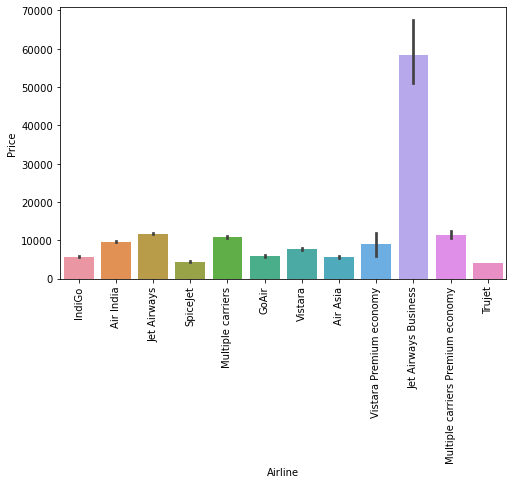

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(x="Airline",y="Price",data=train_df)
plt.xticks(rotation=90)
plt.show()

### -->From barplot we clearly see that the fare of Jet Airways Business is much higher than other

### Now we convert categorical value into numarical value

* we convert ordinal data using LabelEncoder
* And nominal data using OneHotEncoder

In [14]:
train_df['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [15]:
# here Total_stops are ordinal data so we convert into labelencoding 
train_df['Total_Stops'].replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4},inplace =True)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Airline           10682 non-null  object
 1   Source            10682 non-null  object
 2   Destination       10682 non-null  object
 3   Route             10682 non-null  object
 4   Total_Stops       10682 non-null  int64 
 5   Additional_Info   10682 non-null  object
 6   Price             10682 non-null  int64 
 7   Day_of_Journey    10682 non-null  int64 
 8   Month_of_Journey  10682 non-null  int64 
 9   Arrival_hour      10682 non-null  int64 
 10  Arrival_minute    10682 non-null  int64 
 11  Dep_hour          10682 non-null  int64 
 12  Dep_minute        10682 non-null  int64 
 13  Duration_hour     10682 non-null  int64 
 14  Duration_minute   10682 non-null  int64 
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [17]:
train_df['Total_Stops']=train_df['Total_Stops'].astype(int)

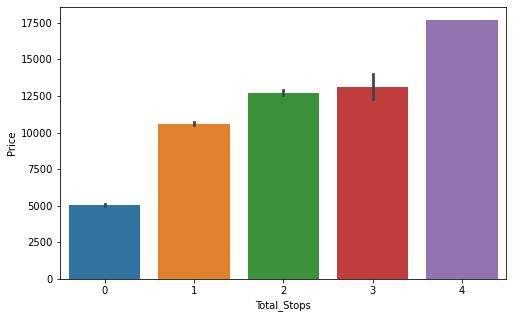

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(x="Total_Stops",y="Price",data=train_df)
plt.show()

* Now we convert nominal categorical data into numeric data using get_dummies

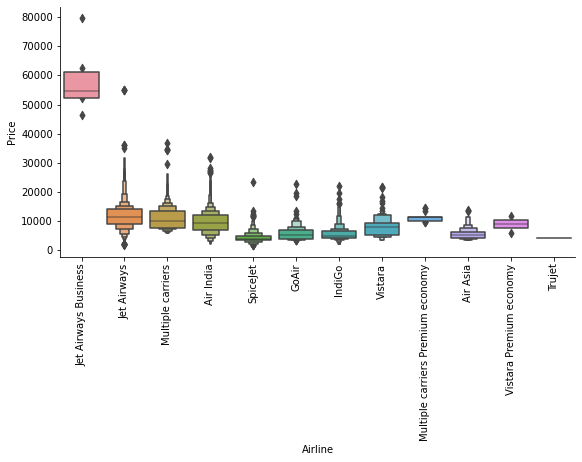

In [19]:
sns.catplot(x='Airline', y='Price', kind = "boxen" , data=train_df.sort_values('Price',ascending=False), height= 4, aspect = 2)
plt.xticks(rotation=90)
plt.show()

In [20]:
train_df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [21]:
airline = pd.get_dummies(train_df['Airline'], drop_first=True)

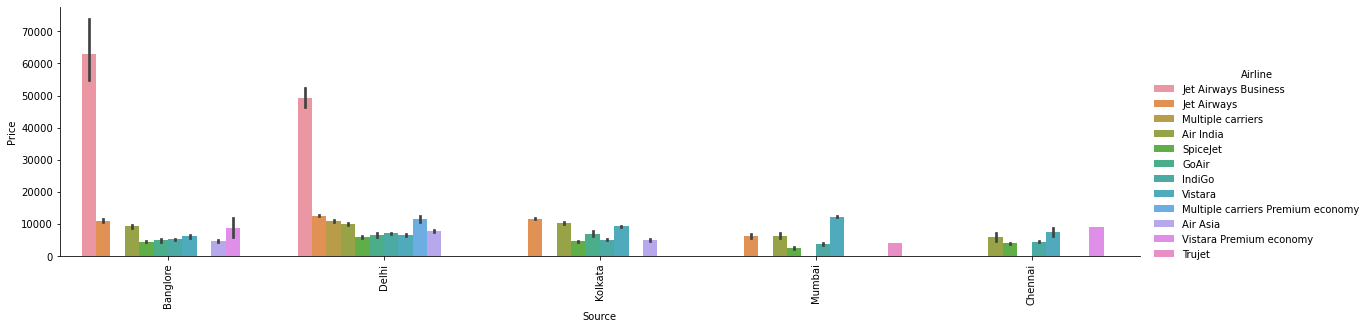

In [22]:
sns.catplot(x='Source', y='Price',hue='Airline', kind = "bar" , data=train_df.sort_values('Price',ascending=False), height= 4, aspect = 4)
plt.xticks(rotation=90)
plt.show()

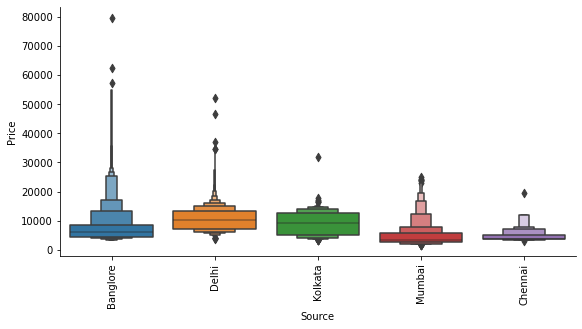

In [23]:
sns.catplot(x='Source', y='Price', kind = "boxen", data=train_df.sort_values('Price',ascending=False), height= 4, aspect = 2)
plt.xticks(rotation=90)
plt.show()

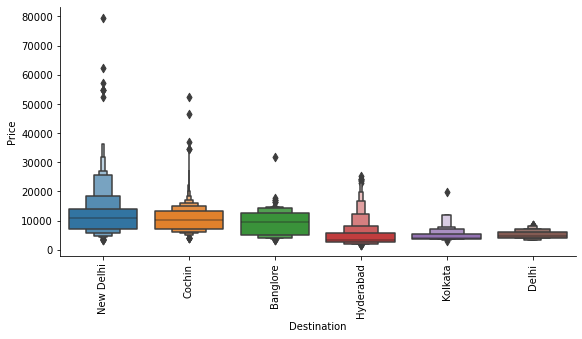

In [24]:
sns.catplot(x='Destination', y='Price', kind = "boxen" , data=train_df.sort_values('Price',ascending=False), height= 4, aspect = 2)
plt.xticks(rotation=90)
plt.show()

In [25]:
train_df['Source'].value_counts()

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

In [26]:
train_df['Destination'].value_counts()

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [27]:
# simmilar way we can convert source and destination
source = pd.get_dummies(train_df['Source'], drop_first=True)
destination = pd.get_dummies(train_df['Destination'], drop_first=True)

* Here Route and Total_Stops give similar type properties so Route and also additional_info does not provide any information so we can drop these column and we can also drop  Airline, source, Destination Column because we convert them into numerical

In [28]:
train_df.drop(['Route','Additional_Info','Airline','Destination', 'Source'] , axis=1 ,inplace = True)

In [29]:
train_df.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Arrival_hour,Arrival_minute,Dep_hour,Dep_minute,Duration_hour,Duration_minute
0,0,3897,24,3,1,10,22,20,2,50
1,2,7662,5,1,13,15,5,50,7,25
2,2,13882,6,9,4,25,9,25,19,0
3,1,6218,5,12,23,30,18,5,5,25
4,1,13302,3,1,21,35,16,50,4,45


* Now we can concate catagorical data and train_df dataset

In [30]:
train_data = pd.concat([train_df, airline, source, destination], axis=1)

In [31]:
train_data.head()

,Total_Stops,Price,Day_of_Journey,Month_of_Journey,Arrival_hour,Arrival_minute,Dep_hour,Dep_minute,Duration_hour,Duration_minute,...,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,3897,24,3,1,10,22,20,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,5,1,13,15,5,50,7,25,...,0,0,0,1,0,0,0,0,0,0
2,2,13882,6,9,4,25,9,25,19,0,...,0,0,1,0,0,1,0,0,0,0
3,1,6218,5,12,23,30,18,5,5,25,...,0,0,0,1,0,0,0,0,0,0
4,1,13302,3,1,21,35,16,50,4,45,...,0,0,0,0,0,0,0,0,0,1


In [32]:
train_data.shape

(10682, 30)

## Same thing we can do with Test data

In [33]:
test_df = pd.read_excel("Test_set_Flight.xlsx")
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [34]:
test_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

* There is no null value

### In the dataset there are many columns in date and time format so we can convert that column in proper format same as train data

In [35]:
# convert date into day of journey and month of journey
test_df['Day_of_Journey'] = pd.to_datetime(test_df['Date_of_Journey']).dt.day
test_df['Month_of_Journey'] = pd.to_datetime(test_df['Date_of_Journey']).dt.month

# drop the Date_of_Journey column
test_df.drop('Date_of_Journey',axis=1, inplace=True)

In [36]:
# convert Arrival_time into Hour and minute 
test_df['Arrival_hour'] = pd.to_datetime(test_df['Arrival_Time']).dt.hour
test_df['Arrival_minute'] = pd.to_datetime(test_df['Arrival_Time']).dt.minute

# drop Arrival_time
test_df.drop('Arrival_Time', axis=1, inplace =True)

# convert Dep_Time into Hour and minute 
test_df['Dep_hour'] = pd.to_datetime(test_df['Dep_Time']).dt.hour
test_df['Dep_minute'] = pd.to_datetime(test_df['Dep_Time']).dt.minute

# drop Dep_Time
test_df.drop('Dep_Time', axis=1, inplace =True)

# Now we convert Duration into proper format into Duration_hour and Duration_minute
duration = list(test_df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i]=duration[i] + " 0m"  # add 0 minute in hour
        else:
            duration[i] = "0h " + duration[i]  # add 0 hour in minute
duration_hour = []
duration_minute = []
for i in range(len(duration)):
    duration_hour.append(int(duration[i].split("h")[0]))
    duration_minute.append(int(duration[i].split("m")[0].split()[-1]))
test_df['Duration_hour'] = duration_hour
test_df['Duration_minute'] = duration_minute
test_df.drop('Duration', axis=1, inplace= True)

### Now we convert categorical value into numarical value

In [37]:
# here Total_stops are ordinal data so we convert into labelencoding 
test_df['Total_Stops'].replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4},inplace =True)
test_df['Total_Stops']=test_df['Total_Stops'].astype(int)

# we convert nominal data using get_dummies
airline = pd.get_dummies(test_df['Airline'], drop_first=True)
# simmilar way we can convert source and destination
source = pd.get_dummies(test_df['Source'], drop_first=True)
destination = pd.get_dummies(test_df['Destination'], drop_first=True)

#Drop all categorical and unuseful columns
test_df.drop(['Route','Additional_Info','Airline','Destination', 'Source'] , axis=1 ,inplace = True)

In [38]:
# Now concat data
test_data = pd.concat([test_df, airline, source, destination], axis=1)
test_data.head()

,Total_Stops,Day_of_Journey,Month_of_Journey,Arrival_hour,Arrival_minute,Dep_hour,Dep_minute,Duration_hour,Duration_minute,Air India,...,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,1,6,6,4,25,17,30,10,55,0,...,0,0,1,0,0,1,0,0,0,0
1,1,5,12,10,20,6,20,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,21,5,19,0,19,15,23,45,0,...,0,0,1,0,0,1,0,0,0,0
3,1,21,5,21,0,8,0,13,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,24,6,2,45,23,55,2,50,0,...,0,0,0,0,0,0,1,0,0,0


## Now we are ready to apply Machine Learning Algorithm

In [39]:
train_data.columns

Index(['Total_Stops', 'Price', 'Day_of_Journey', 'Month_of_Journey',
       'Arrival_hour', 'Arrival_minute', 'Dep_hour', 'Dep_minute',
       'Duration_hour', 'Duration_minute', 'Air India', 'GoAir', 'IndiGo',
       'Jet Airways', 'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara',
       'Vistara Premium economy', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai',
       'Cochin', 'Delhi', 'Hyderabad', 'Kolkata', 'New Delhi'],
      dtype='object')

In [40]:
X = train_data[['Total_Stops', 'Day_of_Journey', 'Month_of_Journey',
       'Arrival_hour', 'Arrival_minute', 'Dep_hour', 'Dep_minute',
       'Duration_hour', 'Duration_minute', 'Air India', 'GoAir', 'IndiGo',
       'Jet Airways', 'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara',
       'Vistara Premium economy', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai',
       'Cochin', 'Delhi', 'Hyderabad', 'Kolkata', 'New Delhi']]
y = train_data.iloc[:,1]

In [41]:
X.head()

,Total_Stops,Day_of_Journey,Month_of_Journey,Arrival_hour,Arrival_minute,Dep_hour,Dep_minute,Duration_hour,Duration_minute,Air India,...,Kolkata,Kolkata,Mumbai,Cochin,Delhi,Delhi,Hyderabad,Kolkata,Kolkata,New Delhi
0,0,24,3,1,10,22,20,2,50,0,...,0,0,0,0,0,0,0,0,0,1
1,2,5,1,13,15,5,50,7,25,1,...,1,0,0,0,0,0,0,1,0,0
2,2,6,9,4,25,9,25,19,0,0,...,0,0,0,1,1,0,0,0,0,0
3,1,5,12,23,30,18,5,5,25,0,...,1,0,0,0,0,0,0,1,0,0
4,1,3,1,21,35,16,50,4,45,0,...,0,0,0,0,0,0,0,0,0,1


In [42]:
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

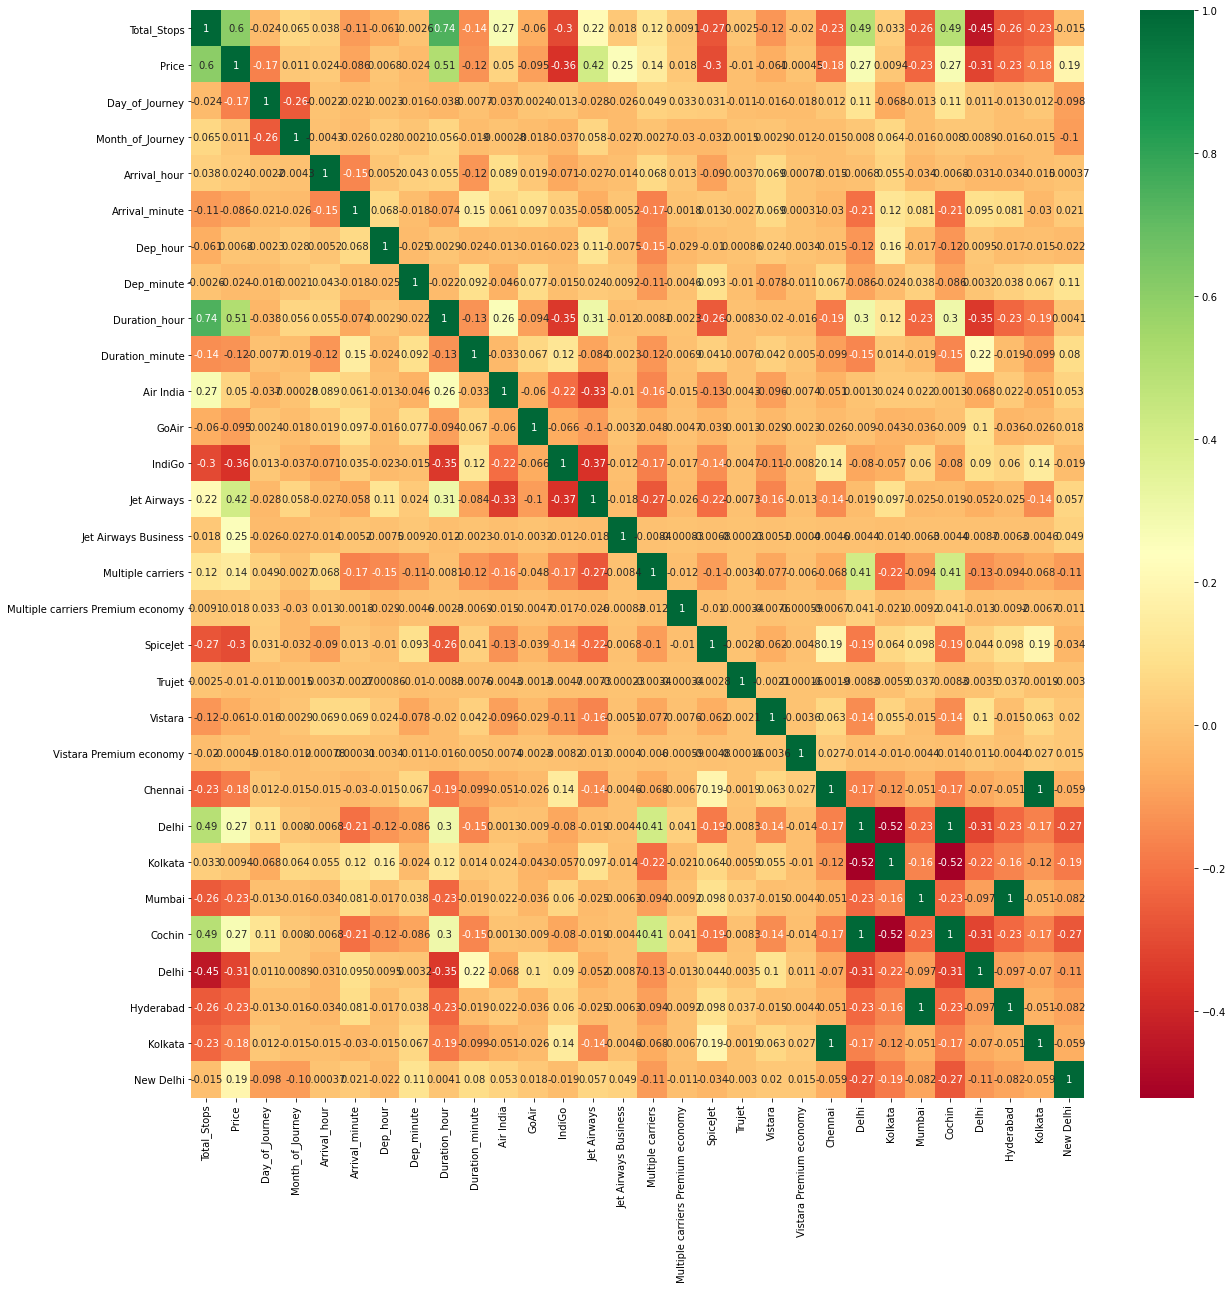

In [43]:
# We can show correlation using heatmap
plt.figure(figsize=(20,20))
sns.heatmap(train_data.corr(),annot=True, cmap='RdYlGn')
plt.show()

In [44]:
from sklearn.ensemble import ExtraTreesRegressor
extratree = ExtraTreesRegressor()
extratree.fit(X,y)

ExtraTreesRegressor()

In [45]:
print(extratree.feature_importances_)

[2.24296493e-01 1.07025447e-01 8.58045220e-02 2.89468922e-02
 2.09758881e-02 2.54355847e-02 2.20285012e-02 1.24412535e-01
 1.78711007e-02 9.83670441e-03 2.04175129e-03 1.72038882e-02
 1.41520910e-01 6.67960184e-02 1.77538271e-02 9.62294671e-04
 3.25263574e-03 1.08701045e-04 5.17959093e-03 1.33759322e-04
 3.01215635e-04 9.36583360e-03 5.91259444e-03 2.33516099e-03
 3.53866933e-04 7.02974236e-03 3.71942515e-03 5.84392671e-03
 1.14196710e-02 6.16781473e-03 2.79077788e-03 3.69371596e-04
 2.28035544e-02]


<AxesSubplot:>

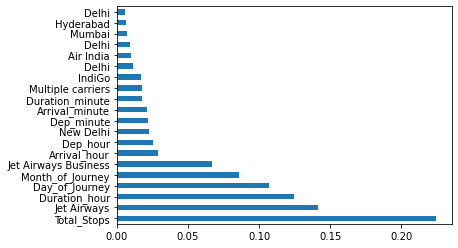

In [46]:
# Now we can see feature importance into graph
feature_imp = pd.Series(extratree.feature_importances_, index = X.columns)
feature_imp.nlargest(20).plot(kind='barh')

In [47]:
x_final = train_data[feature_imp.nlargest(20).index]
x_final.columns

Index(['Total_Stops', 'Jet Airways', 'Duration_hour', 'Day_of_Journey',
       'Month_of_Journey', 'Jet Airways Business', 'Arrival_hour', 'Dep_hour',
       'New Delhi', 'Dep_minute', 'Arrival_minute', 'Duration_minute',
       'Multiple carriers', 'IndiGo', 'Delhi', 'Delhi', 'Air India', 'Delhi',
       'Delhi', 'Mumbai', 'Hyderabad', 'Delhi', 'Delhi'],
      dtype='object')

* we clearly see the feature importance through graph

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
x_train.shape

(8545, 33)

In [50]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

LinearRegression()

In [51]:
y_pred = linear_model.predict(x_test)
y_pred

array([13331.92909367,  8091.61742467,  9552.31817372, ...,
        6528.82018921, 10583.05681835, 11940.34525453])

In [52]:
print(linear_model.score(x_train, y_train))
print(linear_model.score(x_test, y_test))

0.6180995099750229
0.6165577514521261


In [53]:
from sklearn import metrics

In [54]:
print("MAE",metrics.mean_absolute_error(y_test, y_pred))
print("MSE",metrics.mean_squared_error(y_test, y_pred))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE 1993.9150110977127
MSE 8267803.3602525
RMSE 2875.378820303944


In [55]:
print("R^2 score", metrics.r2_score(y_test, y_pred))

R^2 score 0.6165577514521261


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

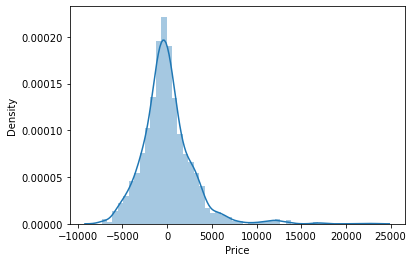

In [56]:
sns.distplot(y_test-y_pred)
plt.plot

In [57]:
svr_model = SVR()
svr_model.fit(x_train, y_train)

SVR()

In [58]:
y_pred2 = svr_model.predict(x_test)
y_pred2

array([8294.989079  , 8370.29247549, 8314.76929115, ..., 8265.66372404,
       8211.15171086, 8233.89561268])

In [59]:
print(svr_model.score(x_train, y_train))
print(svr_model.score(x_test, y_test))

0.003023577122755805
-0.00012047870152787077


In [60]:
print("MAE",metrics.mean_absolute_error(y_test, y_pred2))
print("MSE",metrics.mean_squared_error(y_test, y_pred2))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

MAE 3565.954627389491
MSE 21564654.09270999
RMSE 4643.775844365228


In [61]:
print("R^2 score", metrics.r2_score(y_test, y_pred2))

R^2 score -0.00012047870152787077


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

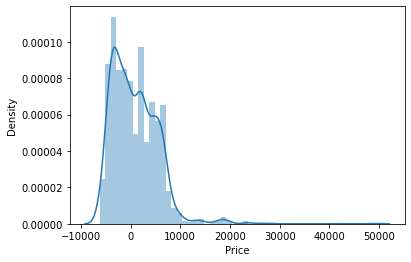

In [62]:
sns.distplot(y_test-y_pred2)
plt.plot

In [63]:
random_model = RandomForestRegressor()
random_model.fit(x_train, y_train)

RandomForestRegressor()

In [64]:
y_pred3 = random_model.predict(x_test)
y_pred3

array([16698.95      ,  6208.45      ,  8868.44      , ...,
        6539.36      , 13062.75333333, 13131.43933333])

In [65]:
print(random_model.score(x_train, y_train))

0.9521077084347614


In [66]:
print(random_model.score(x_test, y_test))

0.7890812655532284


In [67]:
print("MAE",metrics.mean_absolute_error(y_test, y_pred3))
print("MSE",metrics.mean_squared_error(y_test, y_pred3))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))

MAE 1193.8792613161288
MSE 4547841.63196221
RMSE 2132.566911485361


In [68]:
print("R^2 score", metrics.r2_score(y_test, y_pred3))

R^2 score 0.7890812655532284


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

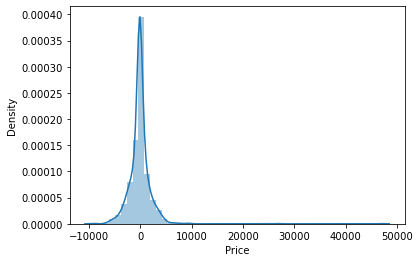

In [69]:
sns.distplot(y_test-y_pred3)
plt.plot

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

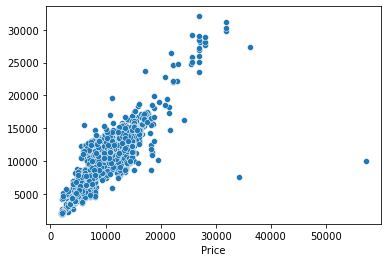

In [70]:
sns.scatterplot(y_test, y_pred3)
plt.plot()

### We can get good accuracy in Random forest so we can apply random forest in this dataset

#### So now we apply hyperparameter tuning using RandomizedSearchCV

In [71]:
from sklearn.model_selection import RandomizedSearchCV

In [72]:
# number of trees in forest
n_estimator= [int(x) for x in np.linspace(100,1200,15)]
#max of feature
max_features = ['auto', 'sqrt']
# max  depth
max_depth = [int(x) for x in np.linspace(5,30,6)]
#number of sample required to sample
min_sample = [5,10,15,20,100]
#  number of sample required to each leaf
min_leaf = [1,2,5,10]

In [73]:
#random grid
random_grid = {
    'n_estimators' : n_estimator,
    'max_depth': max_depth,
    'min_samples_split':min_sample,
    'min_samples_leaf':min_leaf,
    'max_features':max_features
}

In [74]:
# random_search using cross validation 5 and 100 different combination
random_search = RandomizedSearchCV(estimator=random_model, param_distributions=random_grid, scoring='neg_mean_squared_error' , n_iter=10, cv=5)

In [75]:
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [5, 10, 15, 20,
                                                              100],
                                        'n_estimators': [100, 178, 257, 335,
                                                         414, 492, 571, 650,
                                                         728, 807, 885, 964,
                                                         1042, 1121, 1200]},
                   scoring='neg_mean_squared_error')

In [76]:
random_search.best_params_

{'n_estimators': 807,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [77]:
y_predfinal=random_search.predict(x_test)
y_predfinal

array([16891.30414791,  6256.50965059,  8624.50287133, ...,
        6713.8022569 , 12358.91045373, 12612.51311894])

In [78]:
print("MAE",metrics.mean_absolute_error(y_test, y_predfinal))
print("MSE",metrics.mean_squared_error(y_test, y_predfinal))
print("RMSE",np.sqrt(metrics.mean_squared_error(y_test, y_predfinal)))

MAE 1168.6978724271644
MSE 4132186.7269341187
RMSE 2032.7780810836482


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

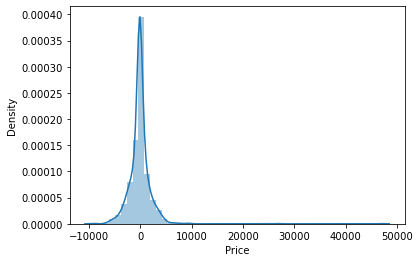

In [79]:
sns.distplot(y_test-y_pred3)
plt.plot

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[]

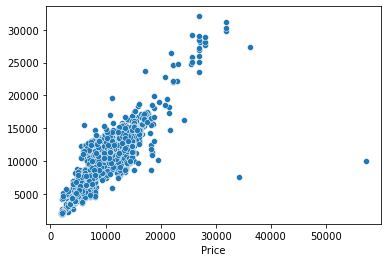

In [80]:
sns.scatterplot(y_test, y_pred3)
plt.plot()

## Save the model

In [81]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle
ERROR: No matching distribution found for pickle


In [82]:
import pickle
# create file to save model
file = open('flight_fare_rf.pkl','wb')

#dump information to that file
pickle.dump(random_search, file)

In [83]:
#load model
model = open('flight_fare_rf.pkl','rb')
forest = pickle.load(model)

In [84]:
y_p = forest.predict(x_test)
metrics.r2_score(y_test, y_p)

0.8083584114236955